# Exploratory Data Analysis (EDA):
This dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks.

Data is also available from Facebook and Google+.

J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.

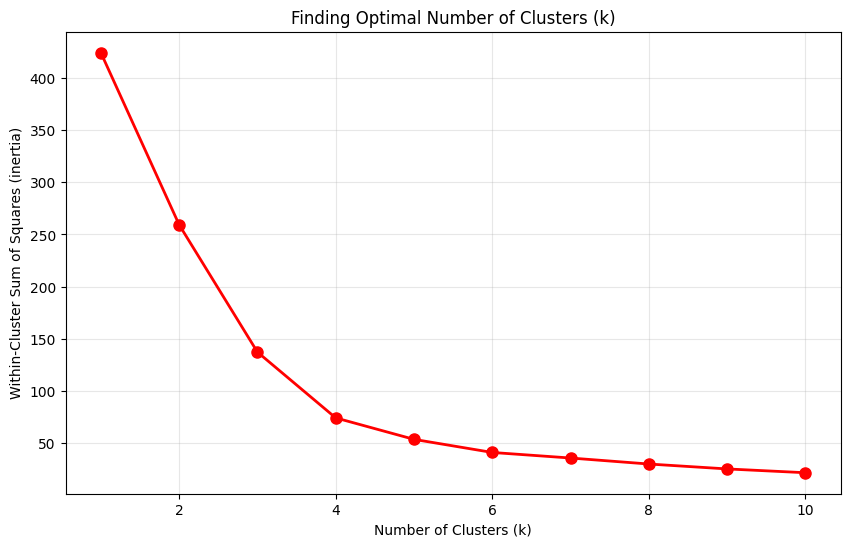

In [ ]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load data
edges = []
with open('twitter_combined.txt', 'r') as f:
    for i, line in enumerate(f):
        if i >= 1000:  # smaller sample for speed
            break
        parts = line.strip().split()
        if len(parts) == 2:
            edges.append((int(parts[0]), int(parts[1])))

   
G = nx.Graph() # building graph and then adding specified stored edges
G.add_edges_from(edges)

# making nodes into list to iterate through 
node_list = list(G.nodes())

# degree
degrees = np.array([G.degree(node) for node in node_list]) # counting connections for each node to determine degree

# clustering coefficient (how interconnected a node's neighbors, value between 0 and 1)
clustering_coeffs = np.array([nx.clustering(G, node) for node in node_list])

# feature matrix
features = np.column_stack([degrees, clustering_coeffs]) # matrix where rows are nodes and columns are (degree, clustering coefficent)

# normalize data
features_scaled = StandardScaler().fit_transform(features)

# inertia for different k values
k_range = range(1, 11)
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=50, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (inertia)')
plt.title('Finding Optimal Number of Clusters (k)')
plt.grid(True, alpha=0.3)
plt.show()

Analyzing 10000 edges
428 nodes, 7174 edges
Feature matrix shape: (428, 2)
K-means clustering with k=4

Clusters:
Cluster 0:
  Size: 79 nodes
  Average degree: 10.63
  Average clustering: 0.143
  Influential nodes: [15150609, 186212304, 25970331]
  Interpretation: Average network users

Cluster 1:
  Size: 121 nodes
  Average degree: 27.79
  Average clustering: 0.749
  Influential nodes: [221036078, 380580781, 229425177]
  Interpretation: Highly connected central nodes

Cluster 2:
  Size: 83 nodes
  Average degree: 95.46
  Average clustering: 0.575
  Influential nodes: [40981798, 43003845, 22462180]
  Interpretation: Highly connected central nodes

Cluster 3:
  Size: 145 nodes
  Average degree: 15.33
  Average clustering: 0.444
  Influential nodes: [294752666, 220068522, 8163442]
  Interpretation: Highly connected central nodes



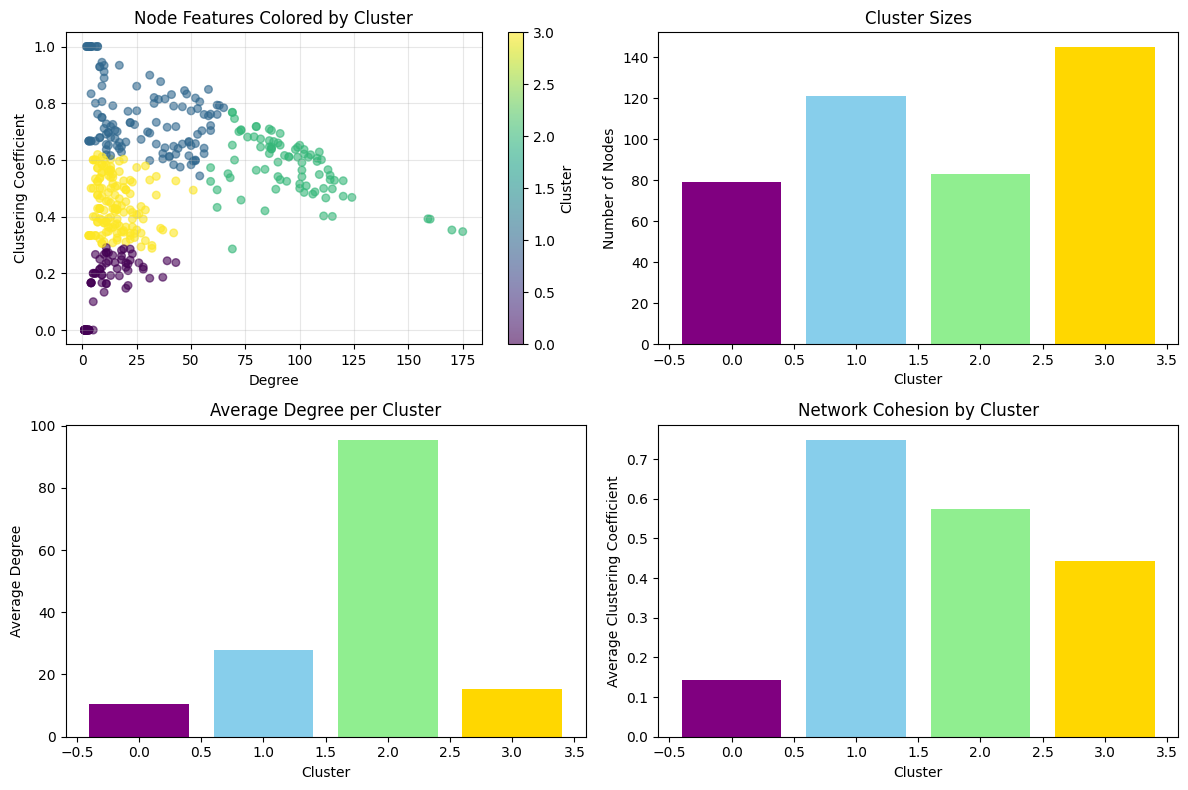

Average degree: 33.52
Average clustering coefficient: 0.500
Number of clusters: 4


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def simple_twitter_clustering():
 
    edges = [] # storing connections

    with open('twitter_combined.txt', 'r') as f:
        for i, line in enumerate(f):
            if i >= 10000:  # limited scope for computational efficiency
                break
            parts = line.strip().split() # getting rid of whitespace and breaking apart 
            if len(parts) == 2: # must find 2 parts to be included in calculations
                source, target = int(parts[0]), int(parts[1]) # conversion to integers
                edges.append((source, target)) 

    print(f"Analyzing {len(edges)} edges")

   
    G = nx.Graph() # building graph and then adding specified stored edges
    G.add_edges_from(edges)

    print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # making nodes into list to iterate through 
    node_list = list(G.nodes())

    # degree
    degrees = np.array([G.degree(node) for node in node_list]) # counting connections for each node to determine degree

    # clustering coefficient (how interconnected a node's neighbors, value between 0 and 1)
    clustering_coeffs = np.array([nx.clustering(G, node) for node in node_list])

    # feature matrix
    features = np.column_stack([degrees, clustering_coeffs]) # matrix where rows are nodes and columns are (degree, clustering coefficent)
    print(f"Feature matrix shape: {features.shape}")

    # normalize/standardize data for manipulation and proper scaling of degree
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    
    optimal_k = 4 # found from scree/elbow plot above

    
    print(f"K-means clustering with k={optimal_k}")
    kmeans = KMeans(n_clusters=optimal_k, random_state=50, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled) # fit model to data for prediction of nodes

    # analysis 
    print("\nClusters:")
    cluster_results = [] # storing cluster information 

    for cluster in range(optimal_k): # loop through clusters
       
        cluster_indices = np.where(cluster_labels == cluster)[0] # indices of nodes in this cluster 

        if len(cluster_indices) == 0:
            continue # skip empty clusters

        cluster_degrees = degrees[cluster_indices] # degrees for nodes in cluster
        cluster_clustering = clustering_coeffs[cluster_indices] # clustering coefficent for nodes in cluster
        cluster_nodes = [node_list[i] for i in cluster_indices] # node IDs for cluster 

        # top 3 nodes by degree
        top_node_indices = np.argsort(cluster_degrees)[-3:][::-1]  # sorted for last 3 in array in descending order
        influential_nodes = [cluster_nodes[i] for i in top_node_indices] 

        # storing information about cluster in a dictionary
        cluster_info = {
            'cluster': cluster,
            'size': len(cluster_indices),
            'avg_degree': np.mean(cluster_degrees),
            'avg_clustering': np.mean(cluster_clustering),
            'influential_nodes': influential_nodes
        }
        cluster_results.append(cluster_info) # storing cluster dictionary information in list from earlier 

        print(f"Cluster {cluster}:")
        print(f"  Size: {len(cluster_indices)} nodes")
        print(f"  Average degree: {np.mean(cluster_degrees):.2f}")
        print(f"  Average clustering: {np.mean(cluster_clustering):.3f}")
        print(f"  Influential nodes: {influential_nodes}")
        print(f"  Interpretation: {cluster_interpretation(cluster_info)}") # calling function for interpretation of results (degree, clustering coefficent elements)
        print()

    # visualizations
    visualization_maker(degrees, clustering_coeffs, cluster_labels, cluster_results)

    return cluster_results


def cluster_interpretation(cluster_info): # classifying cluster based on info about its degree and clustering coefficent 

    avg_deg = cluster_info['avg_degree']
    avg_clust = cluster_info['avg_clustering']

    if avg_deg > 15:
        return "Highly connected central nodes"
    elif avg_deg > 8 and avg_clust > 0.2:
        return "Well-connected tight groups"
    elif avg_clust > 0.3:
        return "Highly interconnected clusters"
    elif avg_deg < 4:
        return "Less connected nodes"
    else:
        return "Average network users"


def visualization_maker(degrees, clustering_coeffs, cluster_labels, cluster_results):

    plt.figure(figsize=(12, 8))

    # degree vs clustering coefficient
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(degrees, clustering_coeffs, c=cluster_labels,
                          cmap='viridis', alpha=0.6, s=30)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Degree')
    plt.ylabel('Clustering Coefficient')
    plt.title('Node Features Colored by Cluster')
    plt.grid(True, alpha=0.3)

    # cluster sizes
    plt.subplot(2, 2, 2)
    cluster_sizes = [result['size'] for result in cluster_results] # using size element from cluster_info dict
    clusters = [result['cluster'] for result in cluster_results] # cluster element from cluster_info dict
    colors = ['purple', 'skyblue', 'lightgreen', 'gold']
    plt.bar(clusters, cluster_sizes, color = colors[:len(clusters)])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Nodes')
    plt.title('Cluster Sizes')

    # average degree per cluster
    plt.subplot(2, 2, 3)
    avg_degrees = [result['avg_degree'] for result in cluster_results] # from cluster_info dict
    plt.bar(clusters, avg_degrees, color = colors[:len(clusters)])
    plt.xlabel('Cluster')
    plt.ylabel('Average Degree')
    plt.title('Average Degree per Cluster')

    # average clustering coefficient per cluster
    plt.subplot(2, 2, 4)
    avg_clustering = [result['avg_clustering'] for result in cluster_results] # from cluster_info dict
    plt.bar(clusters, avg_clustering, color = colors[:len(clusters)])
    plt.xlabel('Cluster')
    plt.ylabel('Average Clustering Coefficient')
    plt.title('Network Cohesion by Cluster')

    plt.tight_layout()
    plt.show()

    # summary statistics
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Average clustering coefficient: {np.mean(clustering_coeffs):.3f}")
    print(f"Number of clusters: {len(cluster_results)}")


if __name__ == "__main__":
    results = simple_twitter_clustering()